In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, pearsonr
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import optuna
import shap


Loading in Data

In [2]:
df = pd.read_csv('../data/insurance.csv')
df.shape
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df1 = df.copy()
df1['sex'] = df1['sex'].astype('category')
df1['smoker'] = df1['smoker'].astype('category')
df1['region'] = df1['region'].astype('category')


Statistical Test

In [4]:
# Categorical vs charges (t-test or ANOVA)
t_smoker = ttest_ind(df1[df1['smoker']=='yes']['charges'], df1[df1['smoker']=='no']['charges'])
print(f"T-test smoker vs non-smoker: p-value = {t_smoker.pvalue}")

t_sex = ttest_ind(df1[df1['sex']=='male']['charges'], df1[df1['sex']=='female']['charges'])
print(f"T-test male vs female: p-value = {t_sex.pvalue}")

anova_region = f_oneway(*(df1[df1['region']==r]['charges'] for r in df1['region'].unique()))
print(f"ANOVA region effect: p-value = {anova_region.pvalue}")

# Numerical vs charges (Pearson correlation test)
for col in ['age', 'bmi', 'children']:
    r, p = pearsonr(df1[col], df1['charges'])
    print(f"{col} correlation with charges: r={r:.3f}, p-value={p:.3e}")

T-test smoker vs non-smoker: p-value = 8.271435842179102e-283
T-test male vs female: p-value = 0.03613272100592976
ANOVA region effect: p-value = 0.0308933560705201
age correlation with charges: r=0.299, p-value=4.887e-29
bmi correlation with charges: r=0.198, p-value=2.459e-13
children correlation with charges: r=0.068, p-value=1.285e-02


In [5]:
df2 = df1.copy()

Test-Train split + transformer setup

In [6]:
#Split predictors and target
Y = df2['charges']
X = df2.drop(columns=['charges'])

#Pull out numeric + categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

#Create train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)




In [7]:
treepreprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        
    ],
    remainder='passthrough'  # keep numeric features as-is
)


XGBoost set up (Without feature engineering)

In [8]:
def objective_stage1(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'learning_rate': 0.1,      # fixed for now
        'n_estimators': 200,       # fixed for now
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor),
        ('regressor', XGBRegressor(**params))
    ])

    # 5-fold CV score
    score = cross_val_score(pipeline, X_train, Y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study1 = optuna.create_study(direction='minimize', study_name="Stage 1 - Tree Complexity")
study1.optimize(objective_stage1, n_trials=50, show_progress_bar=True)

beststage1 = study1.best_params


[I 2025-10-30 12:21:55,311] A new study created in memory with name: Stage 1 - Tree Complexity


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:21:58,794] Trial 0 finished with value: 5300.330727435922 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'gamma': 1.8610749119988816}. Best is trial 0 with value: 5300.330727435922.
[I 2025-10-30 12:22:00,993] Trial 1 finished with value: 4786.586641234149 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.4560225957562771}. Best is trial 1 with value: 4786.586641234149.
[I 2025-10-30 12:22:03,092] Trial 2 finished with value: 5031.79309009977 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'gamma': 1.2542669285303865}. Best is trial 1 with value: 4786.586641234149.
[I 2025-10-30 12:22:05,317] Trial 3 finished with value: 4768.749154639087 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.5324707471848686}. Best is trial 3 with value: 4768.749154639087.
[I 2025-10-30 12:22:07,431] Trial 4 finished with value: 5452.567876086864 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.33888385015229505}. Best is

Best parameters (Stage 1): {'max_depth': 3, 'min_child_weight': 10, 'gamma': 1.9805562645698678}
Best RMSE: {'max_depth': 3, 'min_child_weight': 10, 'gamma': 1.9805562645698678}


C:\Users\user\AppData\Local\Temp\ipykernel_292272\2809548715.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study1)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\2809548715.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study1)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

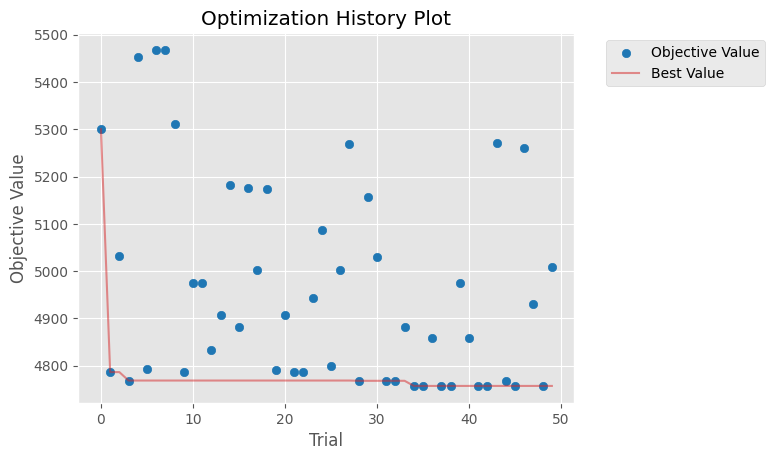

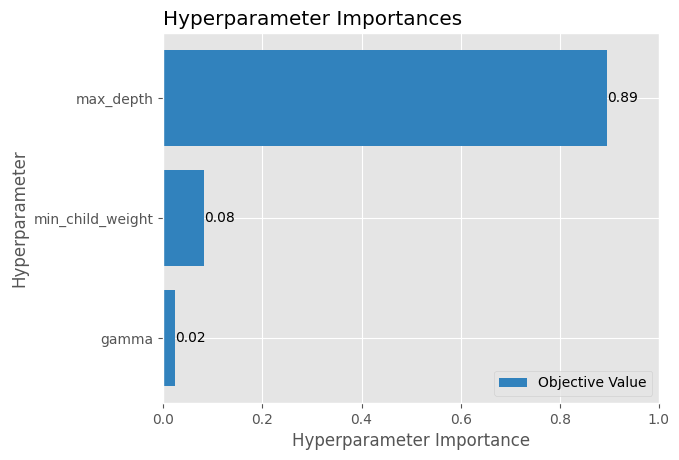

In [9]:
print("Best parameters (Stage 1):", beststage1)
print("Best RMSE:", beststage1)
optuna.visualization.matplotlib.plot_optimization_history(study1)
optuna.visualization.matplotlib.plot_param_importances(study1)


In [10]:
def objective_stage2(trial):
    params = {
        'max_depth': beststage1['max_depth'],
        'min_child_weight': beststage1['min_child_weight'],
        'gamma': beststage1['gamma'],
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor),
        ('regressor', XGBRegressor(**params))
    ])

    score = cross_val_score(pipeline, X_train, Y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study2 = optuna.create_study(direction='minimize', study_name="Stage 2 - Learning Rate")
study2.optimize(objective_stage2, n_trials=50, show_progress_bar=True)

best_stage2 = {**beststage1, **study2.best_params}

[I 2025-10-30 12:22:14,201] A new study created in memory with name: Stage 2 - Learning Rate


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:22:14,526] Trial 0 finished with value: 5343.372953898082 and parameters: {'learning_rate': 0.25724296261555385, 'n_estimators': 557}. Best is trial 0 with value: 5343.372953898082.
[I 2025-10-30 12:22:14,660] Trial 1 finished with value: 5260.416225699645 and parameters: {'learning_rate': 0.20648074862636398, 'n_estimators': 575}. Best is trial 1 with value: 5260.416225699645.
[I 2025-10-30 12:22:14,837] Trial 2 finished with value: 4751.928776867876 and parameters: {'learning_rate': 0.028047500125696626, 'n_estimators': 764}. Best is trial 2 with value: 4751.928776867876.
[I 2025-10-30 12:22:14,932] Trial 3 finished with value: 4584.020040050624 and parameters: {'learning_rate': 0.01500596860521851, 'n_estimators': 302}. Best is trial 3 with value: 4584.020040050624.
[I 2025-10-30 12:22:15,114] Trial 4 finished with value: 5052.97887517496 and parameters: {'learning_rate': 0.10370626101409379, 'n_estimators': 678}. Best is trial 3 with value: 4584.020040050624.
[I 20

Best parameters (Stage 2): {'learning_rate': 0.0105213323762423, 'n_estimators': 380}
Best RMSE: {'learning_rate': 0.0105213323762423, 'n_estimators': 380}


C:\Users\user\AppData\Local\Temp\ipykernel_292272\3097514429.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\3097514429.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

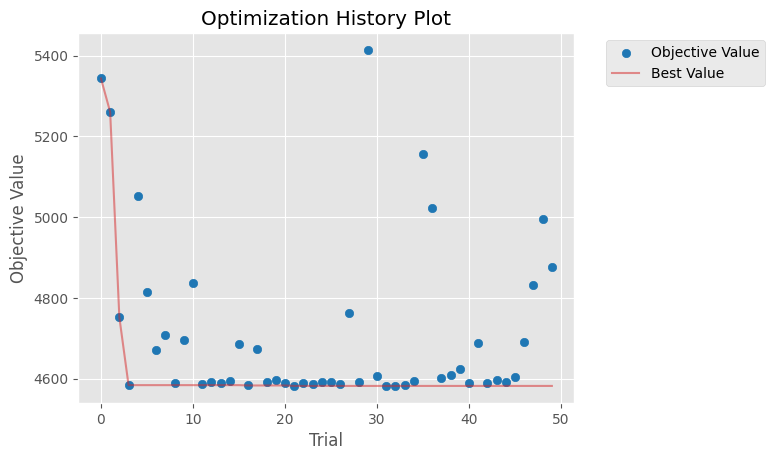

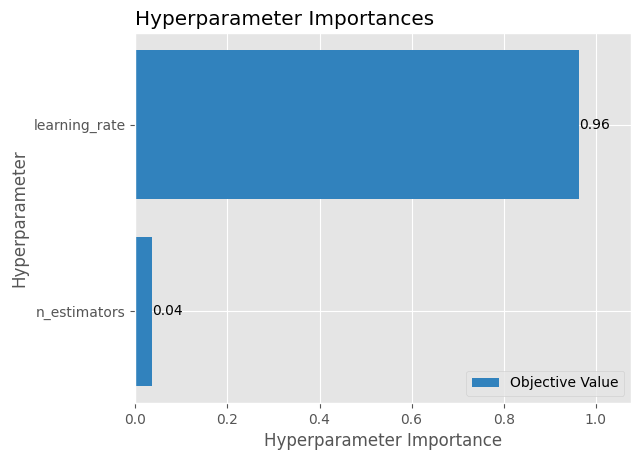

In [11]:
print("Best parameters (Stage 2):", study2.best_params)
print("Best RMSE:", study2.best_params)
optuna.visualization.matplotlib.plot_optimization_history(study2)
optuna.visualization.matplotlib.plot_param_importances(study2)

In [12]:
def objective_stage3(trial):
    params = {
        'max_depth': best_stage2['max_depth'],
        'min_child_weight': best_stage2['min_child_weight'],
        'gamma': best_stage2['gamma'],
        'learning_rate': best_stage2['learning_rate'],
        'n_estimators': best_stage2['n_estimators'],
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor),
        ('regressor', XGBRegressor(**params))
    ])

    score = cross_val_score(pipeline, X_train, Y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study3 = optuna.create_study(direction='minimize', study_name="Stage 3 - Subsampling")
study3.optimize(objective_stage3, n_trials=50, show_progress_bar=True)

best_stage3 = {**best_stage2, **study3.best_params}

[I 2025-10-30 12:22:21,728] A new study created in memory with name: Stage 3 - Subsampling


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:22:21,923] Trial 0 finished with value: 4756.107291634641 and parameters: {'subsample': 0.9374883115022836, 'colsample_bytree': 0.7339210050350324}. Best is trial 0 with value: 4756.107291634641.
[I 2025-10-30 12:22:22,083] Trial 1 finished with value: 4738.626182870283 and parameters: {'subsample': 0.6380657543310587, 'colsample_bytree': 0.7099088088823657}. Best is trial 1 with value: 4738.626182870283.
[I 2025-10-30 12:22:22,237] Trial 2 finished with value: 4737.922925778573 and parameters: {'subsample': 0.6625951494888433, 'colsample_bytree': 0.6417030361316475}. Best is trial 2 with value: 4737.922925778573.
[I 2025-10-30 12:22:22,431] Trial 3 finished with value: 4574.3088298877965 and parameters: {'subsample': 0.6086110230364477, 'colsample_bytree': 0.8964260858715751}. Best is trial 3 with value: 4574.3088298877965.
[I 2025-10-30 12:22:22,551] Trial 4 finished with value: 4614.970278515813 and parameters: {'subsample': 0.7407050061285179, 'colsample_bytree': 0

Best parameters (Stage 3): {'subsample': 0.6641772327246919, 'colsample_bytree': 0.9729821496432122}
Best RMSE: 4564.947556275261


C:\Users\user\AppData\Local\Temp\ipykernel_292272\185791075.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study3)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\185791075.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study3)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

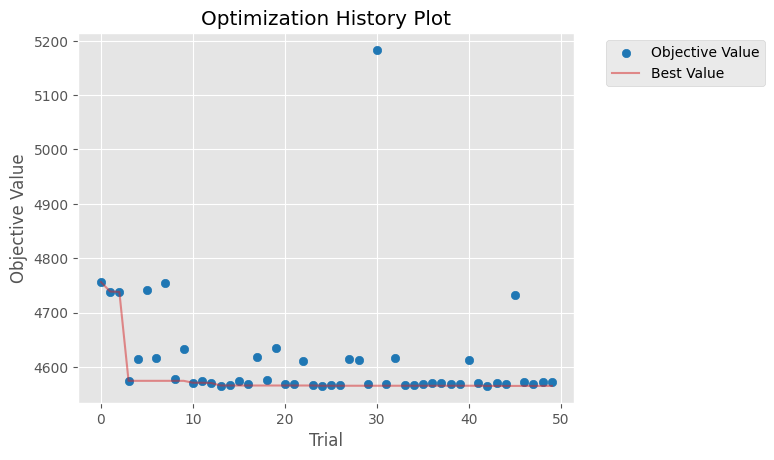

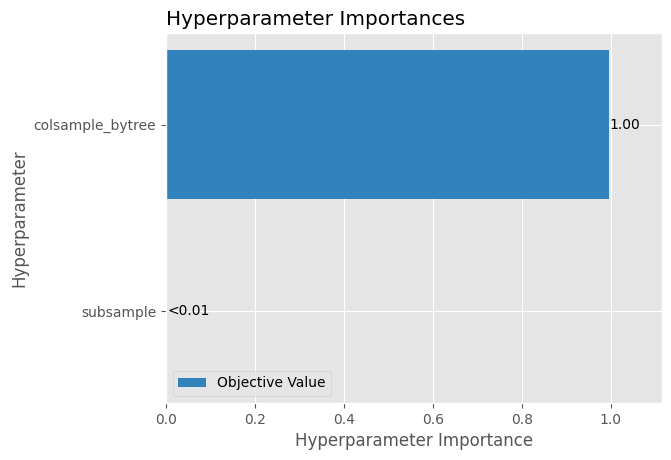

In [13]:
print("Best parameters (Stage 3):", study3.best_params)
print("Best RMSE:", study3.best_value)
optuna.visualization.matplotlib.plot_optimization_history(study3)
optuna.visualization.matplotlib.plot_param_importances(study3)

In [14]:
def objective_stage4(trial):
    params = {
        'max_depth': best_stage3['max_depth'],
        'min_child_weight': best_stage3['min_child_weight'],
        'gamma': best_stage3['gamma'],
        'learning_rate': best_stage3['learning_rate'],
        'n_estimators': best_stage3['n_estimators'],
        'subsample': best_stage3['subsample'],
        'colsample_bytree': best_stage3['colsample_bytree'],
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor),
        ('regressor', XGBRegressor(**params))
    ])

    score = cross_val_score(pipeline, X_train, Y_train,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study4 = optuna.create_study(direction='minimize', study_name="Stage 4 - Regularization")
study4.optimize(objective_stage4, n_trials=50, show_progress_bar=True)

final_params = {**best_stage3, **study4.best_params}

[I 2025-10-30 12:22:31,187] A new study created in memory with name: Stage 4 - Regularization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:22:31,565] Trial 0 finished with value: 4570.343878251304 and parameters: {'reg_alpha': 0.17326464400877817, 'reg_lambda': 2.7354045180262094}. Best is trial 0 with value: 4570.343878251304.
[I 2025-10-30 12:22:31,712] Trial 1 finished with value: 4570.140504545392 and parameters: {'reg_alpha': 0.7682761027968037, 'reg_lambda': 2.8519651026215977}. Best is trial 1 with value: 4570.140504545392.
[I 2025-10-30 12:22:31,958] Trial 2 finished with value: 4570.723617852177 and parameters: {'reg_alpha': 0.7802035065840577, 'reg_lambda': 2.783815747020202}. Best is trial 1 with value: 4570.140504545392.
[I 2025-10-30 12:22:32,152] Trial 3 finished with value: 4564.723432832036 and parameters: {'reg_alpha': 0.44656105333986484, 'reg_lambda': 1.7324651470998196}. Best is trial 3 with value: 4564.723432832036.
[I 2025-10-30 12:22:32,294] Trial 4 finished with value: 4565.811174164998 and parameters: {'reg_alpha': 0.38639054354223723, 'reg_lambda': 0.9407877765241752}. Best is tr

Best parameters (Stage 4): {'reg_alpha': 0.4300480377276433, 'reg_lambda': 1.1920192060529582}
Best RMSE: 4562.723318496222


C:\Users\user\AppData\Local\Temp\ipykernel_292272\3953267629.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study4)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\3953267629.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study4)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

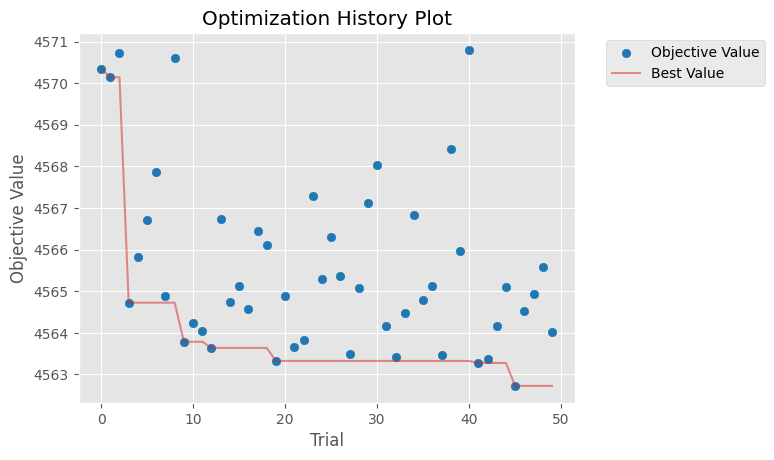

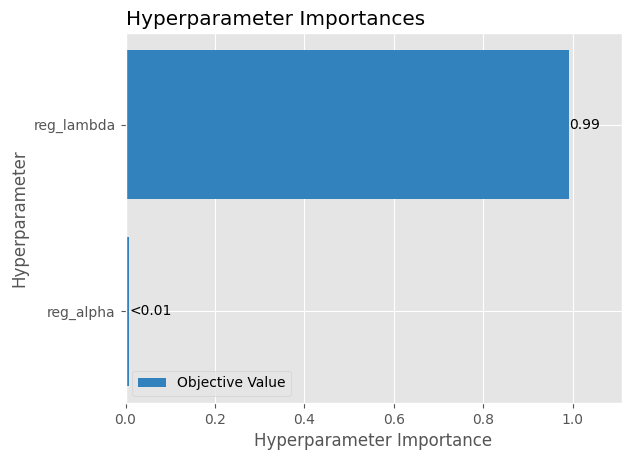

In [15]:
print("Best parameters (Stage 4):", study4.best_params)
print("Best RMSE:", study4.best_value)
optuna.visualization.matplotlib.plot_optimization_history(study4)
optuna.visualization.matplotlib.plot_param_importances(study4)

Final Score (XGBoost without feature engineering)

In [16]:
final_pipeline = Pipeline([
    ('preprocess', treepreprocessor),
    ('regressor', XGBRegressor(**final_params))
])

final_pipeline.fit(X_train, Y_train)

Y_predxgb1 = final_pipeline.predict(X_test)
rmsexgb1 = np.sqrt(mean_squared_error(Y_test, Y_predxgb1))
r2xgb1 = r2_score(Y_test, Y_predxgb1)
print(f"Final Test RMSE: {rmsexgb1:.3f}")
print(f"Final Test R²: {r2xgb1:.3f}")

Final Test RMSE: 4310.733
Final Test R²: 0.880


Text(0, 0.5, 'Predicted')

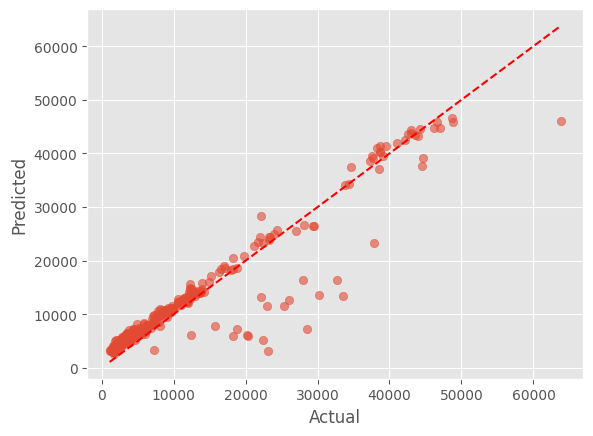

In [17]:
plt.scatter(Y_test, Y_predxgb1, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted')

SHAP Values for XGBoost (Without feature engineering)

ExactExplainer explainer: 269it [00:17, 13.70it/s]                         


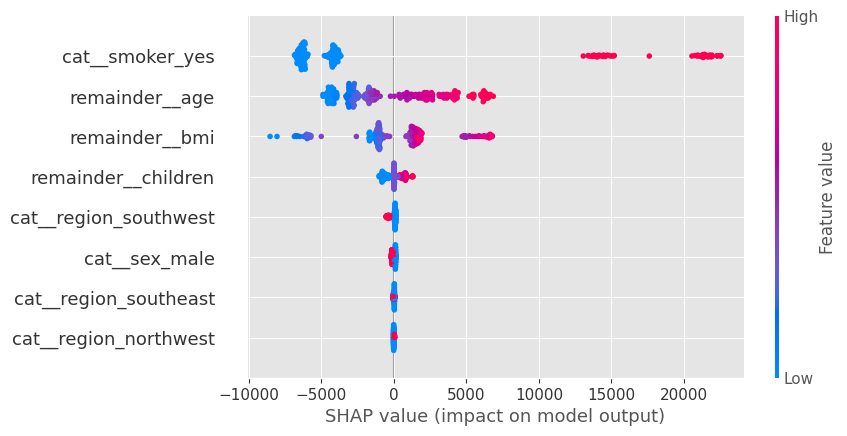

In [18]:
#Preprocess test data
X_test_processed = final_pipeline.named_steps['preprocess'].transform(X_test)
feature_names = final_pipeline.named_steps['preprocess'].get_feature_names_out()

#Use the NEW SHAP API with a small background sample
background = X_test_processed[:200]  # #300 samples for background

#Use generic Explainer (not TreeExplainer)
explainer = shap.Explainer(
    final_pipeline.named_steps['regressor'].predict,
    background,
    feature_names=feature_names
)

#Compute SHAP values
shap_values = explainer(X_test_processed[:300])  # start with 300 for speed

#Plot
shap.plots.beeswarm(shap_values, max_display=15)

SHAP values of target groups due to smoking

In [19]:
# Bin age
X_test['age_group'] = pd.cut(X_test['age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '50+'])

# Add group labels back
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
shap_df['sex'] = X_test['sex'].values
shap_df['region'] = X_test['region'].values
shap_df['age_group'] = X_test['age_group'].values


print("\n=== Average SHAP Impact of Smoking ===")

# Compare average impact of smoking by target groups
smoker_impact = shap_df.groupby('sex')['cat__smoker_yes'].mean().round(2)
print("\nBy sex group:")
print(smoker_impact)
region_impact = shap_df.groupby('region')['cat__smoker_yes'].mean().round(2)
print("\nBy region group:")
print(region_impact)
age_impact = shap_df.groupby('age_group')['cat__smoker_yes'].mean().round(2)
print("\nBy age group:")
print(age_impact)


=== Average SHAP Impact of Smoking ===

By sex group:
sex
female   -1425.44
male       288.88
Name: cat__smoker_yes, dtype: float64

By region group:
region
northeast    -948.65
northwest   -1440.58
southeast    1122.14
southwest   -1639.43
Name: cat__smoker_yes, dtype: float64

By age group:
age_group
<30     -1870.30
30-50     563.16
50+      -610.56
Name: cat__smoker_yes, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_292272\1611096407.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smoker_impact = shap_df.groupby('sex')['cat__smoker_yes'].mean().round(2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\1611096407.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_impact = shap_df.groupby('region')['cat__smoker_yes'].mean().round(2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\1611096407.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

XGBoost 2 with Feature Engineering set up

Feature Engineering

In [20]:
df3 = df.copy()

# Creating BMI groups
df3['bmi_group'] = pd.cut(
    df3['bmi'],
    bins=[0, 18.4, 24.9, 29.9, np.inf],
    labels=[
        "underweight (<18.5)",
        "healthy weight (18.5-24.9)",
        "overweight (25-29.9)",
        "obese (>30)"
    ]
)

df3['sex'] = df['sex']
df3['smoker'] = df['smoker']
df3['region'] = df['region']
# Continuous × continuous or categorical × binary interactions
# Convert smoker to numeric first (if not already)
df3['smoker_num'] = df3['smoker'].map({'yes':1, 'no':0})

# Interactions
df3['bmi_smoker'] = df3['bmi'] * df3['smoker_num']        # very important
df3['age_smoker'] = df3['age'] * df3['smoker_num']        # likely useful
df3['age_bmi'] = df3['age'] * df3['bmi']                  # captures age × BMI effect
df3['smoker_children'] = df3['smoker_num'] * df3['children']
df3['age_children'] = df3['age'] * df3['children']                 # older parents
df3['bmi_children'] = df3['bmi'] * df3['children']                 # larger families may affect BMI impact
df3['age_bmi_smoker'] = df3['age'] * df3['bmi'] * df3['smoker_num'] # high-risk combined effect
df3['bmi_squared'] = df3['bmi'] ** 2                    # squared / non-linear transformations
df3['age_squared'] = df3['age'] ** 2
df3['bmi_children'] = df3['bmi'] * df3['children']
df3['age_children'] = df3['age'] * df3['children']
df3['age_smoker_children'] = df3['age'] * df3['smoker_num'] * df3['children']

#BMI × age × region interactions
# Convert region to one-hot first
region_dummies = pd.get_dummies(df3['region'], prefix='region')
for col in region_dummies.columns:
    df3[f'age_bmi_{col}'] = df3['age'] * df3['bmi'] * region_dummies[col]

#Smoking × region interactions
for col in region_dummies.columns:
    df3[f'smoker_{col}'] = df3['smoker_num'] * region_dummies[col]

#Cubed terms
df3['bmi_cubed'] = df3['bmi'] ** 3
df3['age_cubed'] = df3['age'] ** 3

#BMI × children × smoker
df3['bmi_children_smoker'] = df3['bmi'] * df3['children'] * df3['smoker_num']

#Log transformations
df3['log_bmi'] = np.log1p(df3['bmi'])

# Categorical combinations 
#bmi_group × smoker interaction
bmi_group_dummies = pd.get_dummies(df3['bmi_group'], prefix='bmi_group')
for col in bmi_group_dummies.columns:
    df3[f'{col}_smoker'] = bmi_group_dummies[col] * df3['smoker_num']


df3['sex'] = df3['sex'].astype('category')
df3['smoker'] = df3['smoker'].astype('category')
df3['region'] = df3['region'].astype('category')

#dropping features that are not needed (done through other testing)
drop_features = [
    'children',
    'smoker_children',
    'age_smoker_children',
    'age_bmi_region_northeast',
    'age_bmi_region_northwest',
    'age_bmi_region_southeast',
    'age_bmi_region_southwest',
    'smoker_region_northeast',
    'smoker_region_northwest',
    'smoker_region_southeast',
    'smoker_region_southwest',
    'bmi_squared',
    'bmi_group_underweight (<18.5)_smoker',
    'bmi_group_healthy weight (18.5-24.9)_smoker'
]

# Drop columns
for col in drop_features:
    if col in df3.columns:
        df3.drop(columns=[col], inplace=True)

df3.columns
df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    1338 non-null   int64   
 1   sex                                    1338 non-null   category
 2   bmi                                    1338 non-null   float64 
 3   smoker                                 1338 non-null   category
 4   region                                 1338 non-null   category
 5   charges                                1338 non-null   float64 
 6   bmi_group                              1338 non-null   category
 7   smoker_num                             1338 non-null   int64   
 8   bmi_smoker                             1338 non-null   float64 
 9   age_smoker                             1338 non-null   int64   
 10  age_bmi                                1338 non-null   float

In [21]:
df4 = df3.copy()

Train-Test Split

In [22]:
#Split predictors and target
Y2 = df4['charges']
X2 = df4.drop(columns=['charges'])

#Pull out numeric + categorical features
numeric_features2 = X2.select_dtypes(include=['int64', 'float64']).columns
categorical_features2 = X2.select_dtypes(include=['object', 'category']).columns

#Create train-test split
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    X2, Y2, test_size=0.20, random_state=42
)

X_train2.columns

Index(['age', 'sex', 'bmi', 'smoker', 'region', 'bmi_group', 'smoker_num',
       'bmi_smoker', 'age_smoker', 'age_bmi', 'age_children', 'bmi_children',
       'age_bmi_smoker', 'age_squared', 'bmi_cubed', 'age_cubed',
       'bmi_children_smoker', 'log_bmi',
       'bmi_group_overweight (25-29.9)_smoker',
       'bmi_group_obese (>30)_smoker'],
      dtype='object')

In [23]:
treepreprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features2)
        # No scaler for numeric features
    ],
    remainder='passthrough'  # keep numeric features as-is
)

XGBoost with feature engineering

In [24]:
def objective_stage1_2(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'learning_rate': 0.1,      
        'n_estimators': 200,       
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor2),
        ('regressor', XGBRegressor(**params))
    ])

    # 5-fold CV score
    score = cross_val_score(pipeline, X_train2, Y_train2,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study1_2 = optuna.create_study(direction='minimize', study_name="Stage 1 - Tree Complexity")
study1_2.optimize(objective_stage1_2, n_trials=50, show_progress_bar=True)

beststage1_2 = study1_2.best_params


[I 2025-10-30 12:23:05,709] A new study created in memory with name: Stage 1 - Tree Complexity


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:23:07,298] Trial 0 finished with value: 4797.012943555103 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.6461410855689137}. Best is trial 0 with value: 4797.012943555103.
[I 2025-10-30 12:23:07,608] Trial 1 finished with value: 5012.070949185674 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'gamma': 4.740493685086293}. Best is trial 0 with value: 4797.012943555103.
[I 2025-10-30 12:23:08,135] Trial 2 finished with value: 5278.060814125039 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 4.164783647825546}. Best is trial 0 with value: 4797.012943555103.
[I 2025-10-30 12:23:08,315] Trial 3 finished with value: 4797.012943555103 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'gamma': 4.723598181187923}. Best is trial 0 with value: 4797.012943555103.
[I 2025-10-30 12:23:08,878] Trial 4 finished with value: 5243.424693149582 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 3.084810325577857}. Best is tr

Best parameters (Stage 1): {'max_depth': 3, 'min_child_weight': 10, 'gamma': 1.0032717433344076}
Best RMSE: {'max_depth': 3, 'min_child_weight': 10, 'gamma': 1.0032717433344076}


C:\Users\user\AppData\Local\Temp\ipykernel_292272\3082242765.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study1_2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\3082242765.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study1_2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

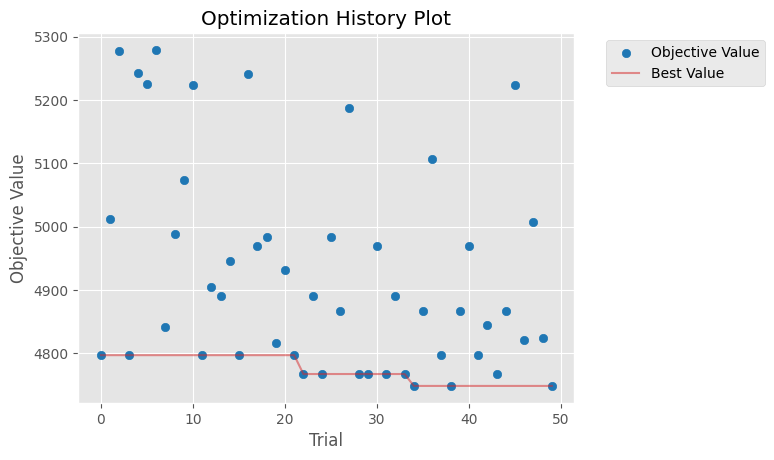

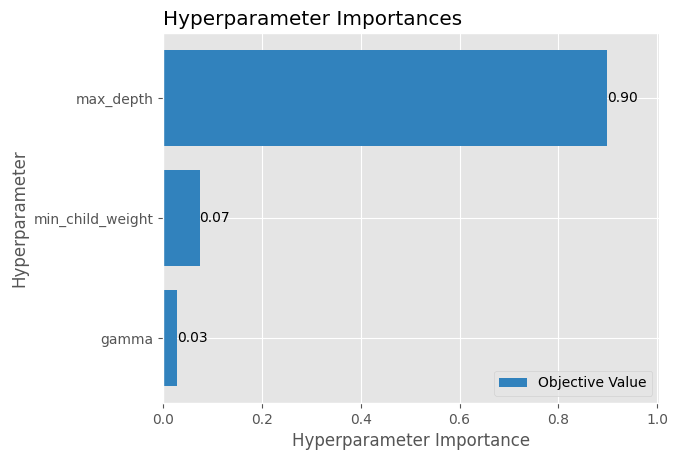

In [25]:
print("Best parameters (Stage 1):", beststage1_2)
print("Best RMSE:", beststage1_2)
optuna.visualization.matplotlib.plot_optimization_history(study1_2)
optuna.visualization.matplotlib.plot_param_importances(study1_2)


In [26]:
def objective_stage2_2(trial):
    params = {
        'max_depth': beststage1_2['max_depth'],
        'min_child_weight': beststage1_2['min_child_weight'],
        'gamma': beststage1_2['gamma'],
        'learning_rate': 0.1,      
        'n_estimators': 200,
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor2),
        ('regressor', XGBRegressor(**params))
    ])

    score = cross_val_score(pipeline, X_train2, Y_train2,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study2_2 = optuna.create_study(direction='minimize', study_name="Stage 2 - Learning Rate")
study2_2.optimize(objective_stage2_2, n_trials=50, show_progress_bar=True)

best_stage2_2 = {**beststage1_2, **study2_2.best_params}

[I 2025-10-30 12:23:20,315] A new study created in memory with name: Stage 2 - Learning Rate


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:23:20,785] Trial 0 finished with value: 4792.260117149428 and parameters: {'subsample': 0.8172344434215414, 'colsample_bytree': 0.9554777840197003}. Best is trial 0 with value: 4792.260117149428.
[I 2025-10-30 12:23:20,945] Trial 1 finished with value: 4778.305551234995 and parameters: {'subsample': 0.9891494620920323, 'colsample_bytree': 0.9297522778808156}. Best is trial 1 with value: 4778.305551234995.
[I 2025-10-30 12:23:21,082] Trial 2 finished with value: 4841.684143660359 and parameters: {'subsample': 0.6571303770571274, 'colsample_bytree': 0.9676256987134575}. Best is trial 1 with value: 4778.305551234995.
[I 2025-10-30 12:23:21,219] Trial 3 finished with value: 4809.999214523367 and parameters: {'subsample': 0.7835503996728093, 'colsample_bytree': 0.9828577081400971}. Best is trial 1 with value: 4778.305551234995.
[I 2025-10-30 12:23:21,427] Trial 4 finished with value: 4815.245999025188 and parameters: {'subsample': 0.7132281296294154, 'colsample_bytree': 0.8

Best parameters (Stage 2): {'subsample': 0.9970968083465098, 'colsample_bytree': 0.7025809703685952}
Best RMSE: {'subsample': 0.9970968083465098, 'colsample_bytree': 0.7025809703685952}


C:\Users\user\AppData\Local\Temp\ipykernel_292272\3459795897.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study2_2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\3459795897.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study2_2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

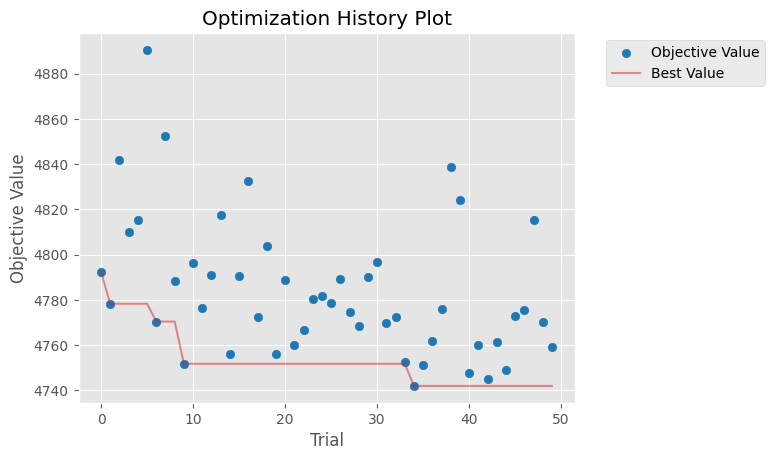

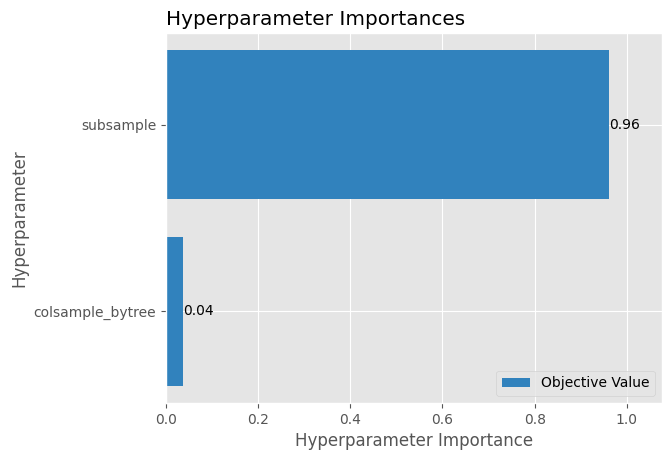

In [27]:
print("Best parameters (Stage 2):", study2_2.best_params)
print("Best RMSE:", study2_2.best_params)
optuna.visualization.matplotlib.plot_optimization_history(study2_2)
optuna.visualization.matplotlib.plot_param_importances(study2_2)

In [28]:
def objective_stage3_2(trial):
    params = {
        'max_depth': best_stage2_2['max_depth'],
        'min_child_weight': best_stage2_2['min_child_weight'],
        'gamma': best_stage2_2['gamma'],
        'learning_rate': 0.1,      
        'n_estimators': 200,
        'subsample': best_stage2_2['subsample'],
        'colsample_bytree': best_stage2_2['colsample_bytree'],
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor2),
        ('regressor', XGBRegressor(**params))
    ])

    score = cross_val_score(pipeline, X_train2, Y_train2,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study3_2 = optuna.create_study(direction='minimize', study_name="Stage 3 - Subsampling")
study3_2.optimize(objective_stage3_2, n_trials=50, show_progress_bar=True)

best_stage3_2 = {**best_stage2_2, **study3_2.best_params}

[I 2025-10-30 12:23:29,562] A new study created in memory with name: Stage 3 - Subsampling


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:23:29,746] Trial 0 finished with value: 4771.728232339841 and parameters: {'reg_alpha': 0.9263110213883343, 'reg_lambda': 0.5937803737859572}. Best is trial 0 with value: 4771.728232339841.
[I 2025-10-30 12:23:29,902] Trial 1 finished with value: 4743.558444017917 and parameters: {'reg_alpha': 0.7402143849351694, 'reg_lambda': 1.0028400557915649}. Best is trial 1 with value: 4743.558444017917.
[I 2025-10-30 12:23:30,046] Trial 2 finished with value: 4734.980981953568 and parameters: {'reg_alpha': 0.25600845430782615, 'reg_lambda': 1.8852296532712602}. Best is trial 2 with value: 4734.980981953568.
[I 2025-10-30 12:23:30,162] Trial 3 finished with value: 4761.021916763697 and parameters: {'reg_alpha': 0.7333343287413081, 'reg_lambda': 1.6360261476779896}. Best is trial 2 with value: 4734.980981953568.
[I 2025-10-30 12:23:30,269] Trial 4 finished with value: 4737.809077252129 and parameters: {'reg_alpha': 0.10658596093730122, 'reg_lambda': 2.9472575128599274}. Best is tr

Best parameters (Stage 3): {'reg_alpha': 0.17405726081722195, 'reg_lambda': 2.7140750001198417}
Best RMSE: 4722.904344156649


C:\Users\user\AppData\Local\Temp\ipykernel_292272\375671199.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study3_2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\375671199.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study3_2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

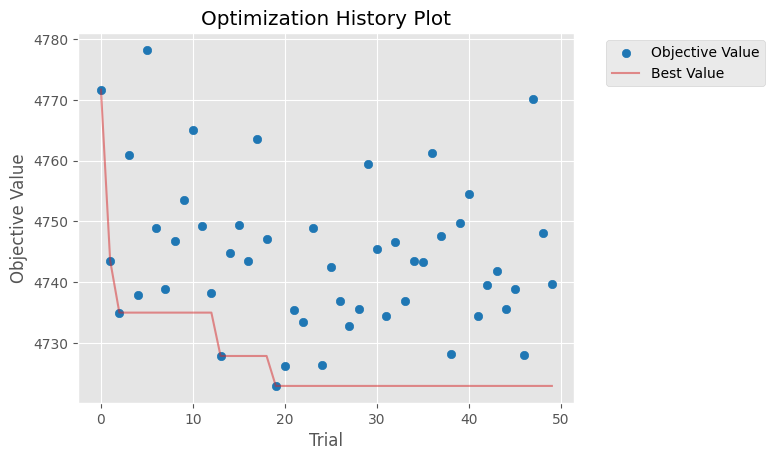

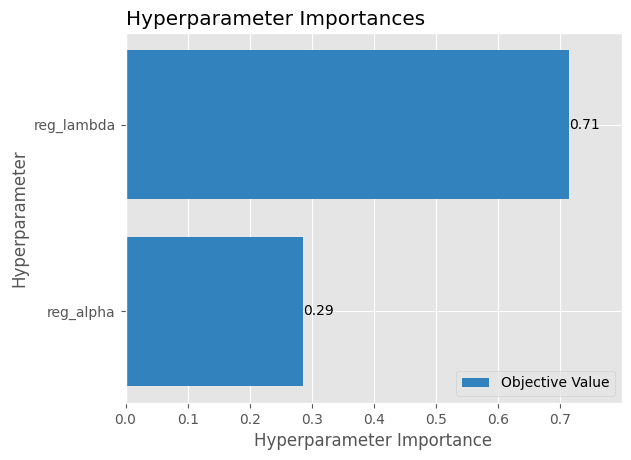

In [29]:
print("Best parameters (Stage 3):", study3_2.best_params)
print("Best RMSE:", study3_2.best_value)
optuna.visualization.matplotlib.plot_optimization_history(study3_2)
optuna.visualization.matplotlib.plot_param_importances(study3_2)

In [30]:
def objective_stage4_2(trial):
    params = {
        'max_depth': best_stage3_2['max_depth'],
        'min_child_weight': best_stage3_2['min_child_weight'],
        'gamma': best_stage3_2['gamma'],
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': best_stage3_2['subsample'],
        'colsample_bytree': best_stage3_2['colsample_bytree'],
        'reg_alpha': best_stage3_2['reg_alpha'],
        'reg_lambda': best_stage3_2['reg_lambda'],
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    pipeline = Pipeline([
        ('preprocess', treepreprocessor2),
        ('regressor', XGBRegressor(**params))
    ])

    score = cross_val_score(pipeline, X_train2, Y_train2,
                            scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1).mean()
    return -score

study4_2 = optuna.create_study(direction='minimize', study_name="Stage 4 - Regularization")
study4_2.optimize(objective_stage4_2, n_trials=50, show_progress_bar=True)

final_params_2 = {**best_stage3_2, **study4_2.best_params}

[I 2025-10-30 12:23:37,597] A new study created in memory with name: Stage 4 - Regularization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 12:23:37,916] Trial 0 finished with value: 4608.854401622322 and parameters: {'learning_rate': 0.03123943451556129, 'n_estimators': 297}. Best is trial 0 with value: 4608.854401622322.
[I 2025-10-30 12:23:38,164] Trial 1 finished with value: 4548.68483283422 and parameters: {'learning_rate': 0.010093652291925777, 'n_estimators': 448}. Best is trial 1 with value: 4548.68483283422.
[I 2025-10-30 12:23:38,238] Trial 2 finished with value: 5110.802898636026 and parameters: {'learning_rate': 0.028820134412461135, 'n_estimators': 59}. Best is trial 1 with value: 4548.68483283422.
[I 2025-10-30 12:23:38,348] Trial 3 finished with value: 4600.438162718296 and parameters: {'learning_rate': 0.05199071845173613, 'n_estimators': 168}. Best is trial 1 with value: 4548.68483283422.
[I 2025-10-30 12:23:38,464] Trial 4 finished with value: 4570.567587785236 and parameters: {'learning_rate': 0.017029738629342876, 'n_estimators': 205}. Best is trial 1 with value: 4548.68483283422.
[I 2025-

Best parameters (Stage 4): {'learning_rate': 0.010093652291925777, 'n_estimators': 448}
Best RMSE: 4548.68483283422


C:\Users\user\AppData\Local\Temp\ipykernel_292272\1362847992.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study4_2)
C:\Users\user\AppData\Local\Temp\ipykernel_292272\1362847992.py:4: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study4_2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

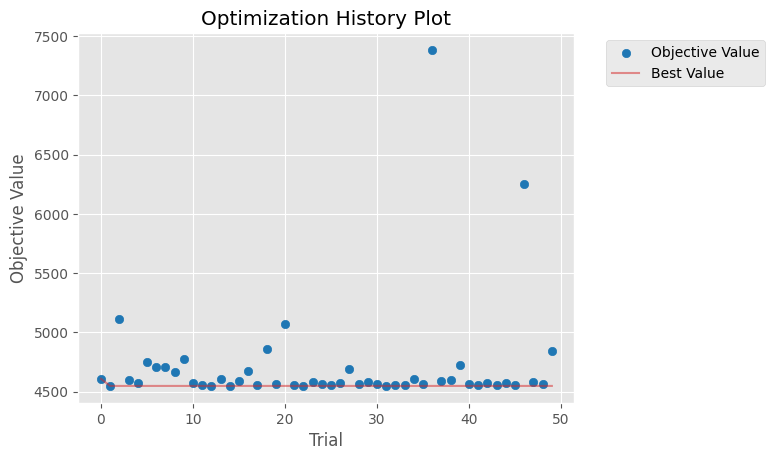

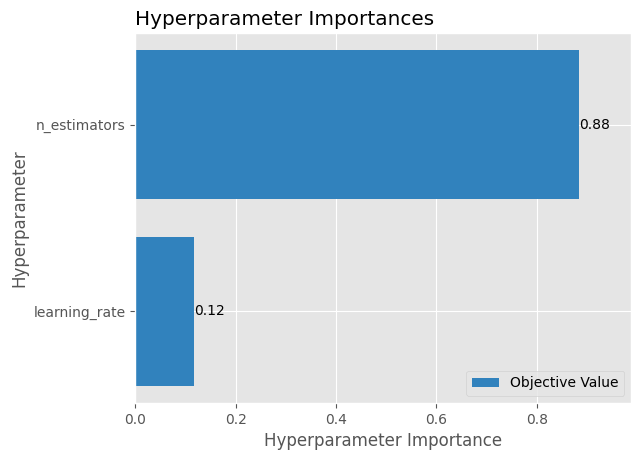

In [31]:
print("Best parameters (Stage 4):", study4_2.best_params)
print("Best RMSE:", study4_2.best_value)
optuna.visualization.matplotlib.plot_optimization_history(study4_2)
optuna.visualization.matplotlib.plot_param_importances(study4_2)

Final Test Scores (XGBoost feature engineering)

In [32]:
final_pipeline_2 = Pipeline([
    ('preprocess', treepreprocessor2),
    ('regressor', XGBRegressor(**final_params))
])

final_pipeline_2.fit(X_train2, Y_train2)

Y_predxgb2 = final_pipeline_2.predict(X_test2)
rmsexgb2 = np.sqrt(mean_squared_error(Y_test2, Y_predxgb2))
r2xgb2 = r2_score(Y_test2, Y_predxgb2)
print(f"Final Test RMSE: {rmsexgb2:.3f}")
print(f"Final Test R²: {r2xgb2:.3f}")

Final Test RMSE: 4259.873
Final Test R²: 0.883


SHAP beeswarm

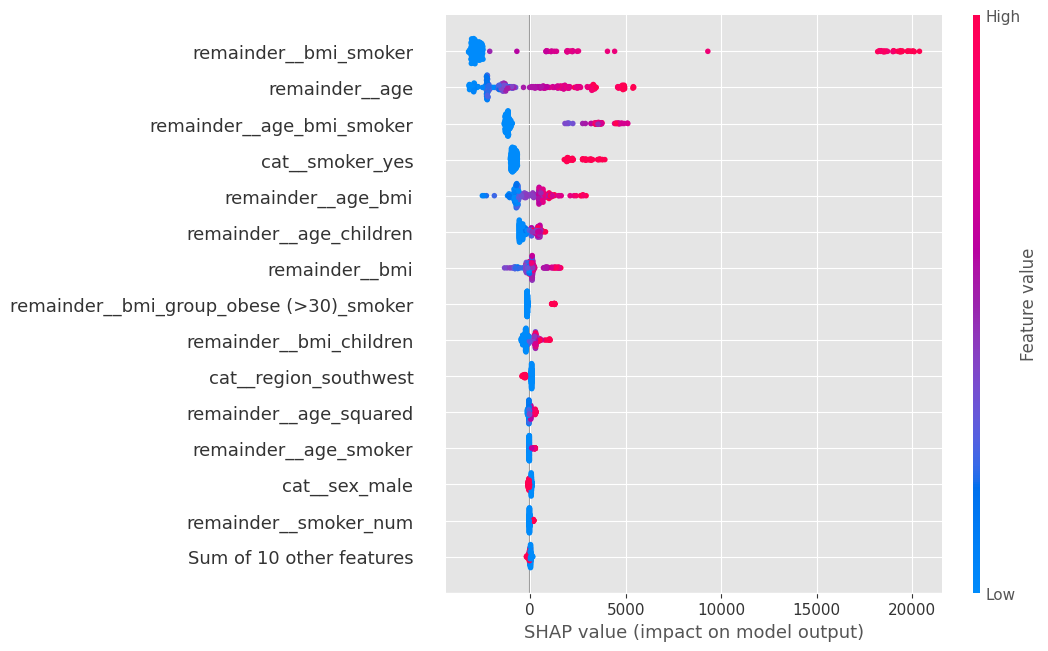

In [33]:
#Preprocess test data
X_test_processed2 = final_pipeline_2.named_steps['preprocess'].transform(X_test2)
feature_names2 = final_pipeline_2.named_steps['preprocess'].get_feature_names_out()

#Use the NEW SHAP API with a small background sample
background2 = X_test_processed2[:200]  

#Use generic Explainer (not TreeExplainer)
explainer2 = shap.Explainer(
    final_pipeline_2.named_steps['regressor'].predict,
    background2,
    feature_names=feature_names2
)

#Compute SHAP values
shap_values2 = explainer2(X_test_processed2[:300]) 
#Plot
shap.plots.beeswarm(shap_values2, max_display=15)